# Linear Classification

In [1]:
# PREAMBLE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import scipy

%matplotlib inline
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

## Classifying Rock Types

Our next real world example will be from geology.
More precisely from *rock physics*, which studies the relation between physical and elastic properties of rocks and is the basis of quantitative seismic interpretation.
In this scenario, we got the following data set with the task to distinguish between shale and sand rock types.
As sample of the data looks as follows.

In [2]:
df = pd.read_csv('rocktypes.csv', sep=' ')
print(df)

             Ip     VpVs   type
0    5380.91035  2.45010  shale
1    5376.78660  2.44106  shale
2    5387.72309  2.46131  shale
3    5404.29744  2.50455  shale
4    5423.06432  2.52649  shale
..          ...      ...    ...
426  5599.97927  2.29973   sand
427  5936.40102  2.47151   sand
428  5853.23512  2.40709   sand
429  5200.00000  2.10000  shale
430  6200.00000  2.40000  shale

[431 rows x 3 columns]


In order to feed the data to an algorithm, we have to convert the string 'type' to a numerical label ($\{-1, +1\}$ in this case).
Create a new column 'label' which contains the value 1 if the type is 'sand' and -1 otherwise.

In [3]:
df["label"] = df.apply(lambda row: 1 if (row.type == "sand") else -1, axis=1)

In [4]:
# assert that the label column is correct
np.testing.assert_array_equal(np.sum(df['label']== 1), 173)
np.testing.assert_array_equal(np.sum(df['label']==-1), 258)

### Exploring the data

Before starting on any task, it is often useful to understand the data by visualizing it. Our expert in the field tells us, that we should have a look at *acoustic impedance* (`Ip`), which is a product of velocity `Vs` and density RHO as well as the velocity ratio of the *p-wave* and *s-wave velocities* (`Vp/Vs`).

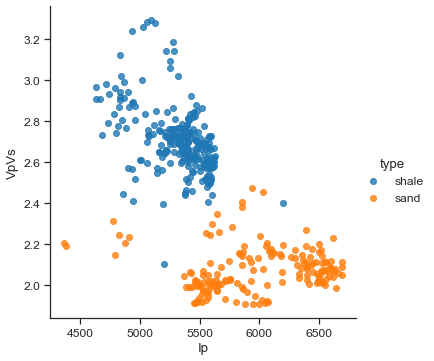

In [5]:
sns.lmplot(x='Ip', y='VpVs', hue='type', data=df, fit_reg=False)

### Feature Scaling

1. Scale the columns `df['Ip']` and `df['VpVs']` such that they have zero mean and unit variance.
Do not overwrite the columns, but create new ones as `df['Ip Normalized']` and `df['VpVs Normalized']`.
2. Add a bias column `df['Bias']`.
3. Plot the normalized data.

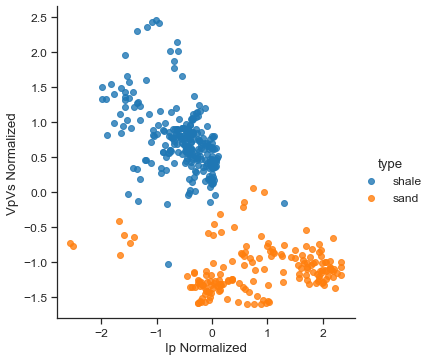

In [6]:
df['Ip Normalized'] = (df['Ip'] - df['Ip'].mean(axis=0)) / df['Ip'].std(axis=0)
df['VpVs Normalized'] = (df['VpVs'] - df['VpVs'].mean(axis=0)) / df['VpVs'].std(axis=0)

df['Bias'] = np.ones(df.shape[0])

sns.lmplot(x='Ip Normalized', y='VpVs Normalized', hue='type', data=df, fit_reg=False)

In [7]:
# export pandas dataframe to numpy array
X = df[['Ip Normalized','VpVs Normalized','Bias',]].values 
y = df['label'].values
(n,d) = X.shape

print(f"Dimensions X: {X.shape}, y: {y.shape}")

Dimensions X: (431, 3), y: (431,)


### The Logistic Loss

Implement the logistic loss function
$$
l(\hat{y}, y) = \log( 1+\exp( -y \cdot \hat{y} )),
$$
where $\hat{y}$ is the output of the model.

In [8]:
def logistic_loss(yhat, y):
    return np.log(1 + np.exp(-y * yhat))

In [9]:
# test logistic loss implementation
np.testing.assert_array_almost_equal(logistic_loss([-2,0,1], y[:3]),[0.13, 0.69, 1.31], decimal=2) 

First, create the hypothesis function $h_w(X) = Xw$ with

\begin{equation*}
	X = \begin{bmatrix}
		~-~ \vec{x}_1^{\intercal} ~-~~ \\
		~-~ \vec{x}_2^{\intercal} ~-~~ \\
		\vdots                                       \\
		~-~ \vec{x}_m^{\intercal} ~-~~ \\
	\end{bmatrix}
	\in \mathbb{R}^{m\times n},
	\quad
	\vec{y} = \begin{bmatrix}
		y_1    \\
		y_2    \\
		\vdots \\
		y_m    \\
	\end{bmatrix}
	\in \mathbb{R}^{m}
\end{equation*}

as in the first exercise.

In [10]:
# implement a linear hypothesis function 
def h(w,X): 
    """
    model/hyothesis
    :param w: weights/paramters
    :param X: data matrix with x_i^T in the ith row
    """
    return np.dot(X, w)

In [11]:
# test the hypotesis and cost function for w = [1,1]
w = np.ones(d)

# test the first 3 values calculated by h
np.testing.assert_array_almost_equal(h(w,X)[:3], [ 0.57, 0.54, 0.62 ], decimal=2) 

In [12]:
# cost function
def J(w, X, y):
    """
    objective function
    :param loss: the loss function to use
    :param w: weights/paramters
    :param X: data matrix with x_i^T in the ith row
    :param y: vector of labels
    """
    yhat = h(w,X)
    errors = logistic_loss(yhat, y)
    return np.mean( errors, axis=0 ) 

In [13]:
# compute the cost function for w = [1,1,1]
w = np.ones(d)
print(f"J([1,1,1]) = {J(w,X,y)}")
np.testing.assert_array_almost_equal(J(w,X,y), 1.10248, decimal=2) # test the cost function

J([1,1,1]) = 1.1024853044733678


### Implementing gradient descent

Now that we have the hypothesis and the cost function we can implement the gradient descent routine. First, write a function $\nabla J(w)$ which returns the gradient of the cost function. The gradient is just a vector with all the partial derivatives
$$
\nabla J(w) = \bigg[\frac{\partial J(w)}{\partial w_1} , \dotsc, \frac{\partial J(w)}{\partial w_d} \bigg]^T
$$

In [14]:
# implement the gradient of the cost function for logistic regression
def dJ(w, X, y): 
    """
    gradient of objective function
    :param w: weights/paramters
    :param X: data matrix with x_i^T in the ith row
    :param y: vector of labels
    :return gradient of J with respect to w
    """
    dj = 0
    for i in range(0,len(X)):
        dj = dj + (1/len(X))*((-y[i]*X[i]) / (1 + np.e**(y[i]*h(w,X[i].T))))
    return dj

In [15]:
w = np.ones(3)

assert dJ(w,X,y).shape == (3,) # we expect a vector of size (3,)
np.testing.assert_almost_equal(scipy.optimize.check_grad(J, dJ, w, X, y), 0.0, decimal=3) # test the gradient

Next, you will implement gradient descent in the function.
Recall the update rule of gradient descent which is
$$
w^{t+1} = w^{t} - \alpha \nabla J(w^{t})
$$

In order to inspect the performance of the algorithm it is necessary to store the weights $w^{t}$ at each iteration $t = 1,\dots,iters$.

In [16]:
def gradientDescent(dJ, X, y, w0, alpha, iters):
    """
    function that performs gradient descent
    :param w: weights/paramters
    :param X: data matrix with x_i^T in the ith row
    :param y: vector of labels
    :return the optimal weights and a list of all weights calculated
    """
    w = w0                           # initial weights
    ws = np.zeros([iters, len(w0)])  # memory to remember weights
    for t in range(iters):           # for t = 1, ..., iters
        w = w - alpha * dJ(w, X, y)
        ws[t,:] = w
    return w, ws

We can now use gradient descent to find the optimal parameters for $J$.

Optimal weights $w: [ 0.80983897, -5.27887244, -1.26449745]$

In [17]:
w0 = np.zeros(d) # initial weights
alpha = 1        # learning rate
iters = 200      # number of iterations

w, ws = gradientDescent(dJ, X, y, w0, alpha, iters)
print(f"optimal weights w: {w}")

optimal weights w: [ 0.80983897 -5.27887244 -1.26449745]


### Verifying Gradient Descent

A good way to verify that gradient descent is working correctly is to look at the values $J(w)$ and check that it is decreasing with each step.
Compare the following plot ti Fig. 2.7 in the script.

<AxesSubplot:xlabel='Iterations', ylabel='Cost'>

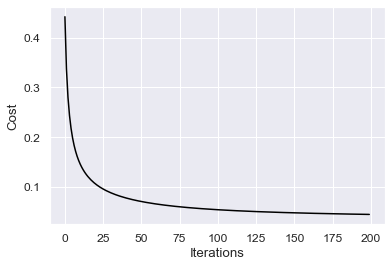

In [18]:
def plot_progress(costs, log=False):
    with sns.axes_style("darkgrid"):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(costs)), costs, 'k')
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Cost')
        if log:
            ax.set_yscale('log')
        return ax
    
plot_progress([J(w,X,y) for w in ws])

Create a function that calculates the mean zero-one loss on the data set for a given paramerer $w$ with the goal to recreate Fig. 2.7 (right).

In [19]:
def zero_one_loss(w, X, y):
    predictions = h(w, X)
    losses = np.where(predictions * y < 0, 1, 0)
    return sum(losses)/losses.shape[0]

<AxesSubplot:xlabel='Iterations', ylabel='Cost'>

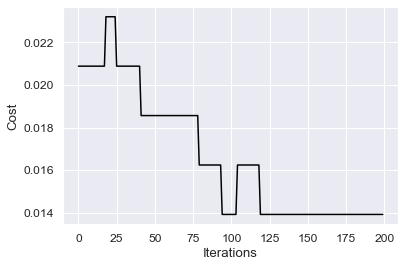

In [20]:
plot_progress([zero_one_loss(w, X, y) for w in ws])

We use the final paramers to plot the linear fit.
Compare this to Fig. 2.8 in the script.

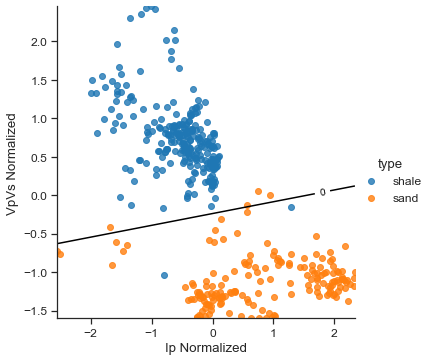

In [21]:
def plot_fit(h, w, levels=[0]):
    x_range = df['Ip Normalized'].min(), df['Ip Normalized'].max()
    y_range = df['VpVs Normalized'].min(), df['VpVs Normalized'].max()
    sns.lmplot(x='Ip Normalized', y='VpVs Normalized', hue='type', data=df, fit_reg=False)
    grid = 100
    xx,yy = np.meshgrid(np.linspace(x_range[0], x_range[1], grid), np.linspace(y_range[0], y_range[1], grid))
    XY = np.array([np.ravel(xx), np.ravel(yy), np.ones((grid*grid,))]).T
    P = h(w, XY).reshape(grid, grid)
    cn = plt.contour(xx, yy, P, colors='k',levels=levels)
    plt.clabel(cn, inline=1, fontsize=10)
    
plot_fit(h, w)    

Estimate the label of a sample with `Ip=6000` and `VpVs=3.0`.

### Probabilistic Prediction

Implement the logistic function
$$
\sigma(z) = \frac{1}{1+\exp(-z)}
$$
in order to make probabilistic prediction.
Compare the result to Fig. 3.6 in the script.

In [22]:
def logistic(z):
    return 1 / (1 + np.exp(-z))

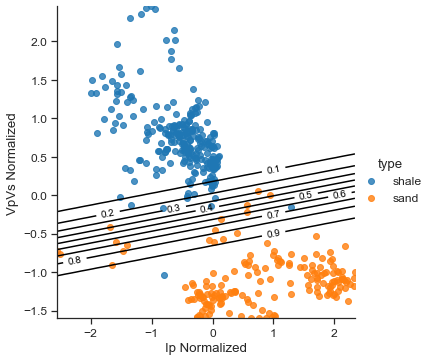

In [23]:
# squash the output of h thought the logistic function.
plot_fit(lambda w, X: logistic(h(w, X)), w, levels=10)   

# Linear Support Vector Machine

In this section we implement a linear support vector machine using the hinge loss, but without the regularization term (we will discuss this in the next chapters):

\begin{align*}
	l_{\text{hinge}}(h_w(x), y)
	 & = \max \{0, 1-y\cdot h_w(x)\}          
\end{align*}

The objective is then

\begin{equation*}
J(w) = \frac{1}{m} \sum_{i=1}^m \max \{0, 1-y\cdot h_w(x)\}
\end{equation*}


In [24]:
# gradient of J with respect to w
def J_SVM(w, X, y): 
    """
    The SVM objective function
    :param w: weights/paramters
    :param X: data matrix with x_i^T in the ith row
    :param y: vector of labels
    :return J
    """
    J = 0
    for i in range(0,len(X)):
        J = J + (1/len(X))*max(0,1-y[i]*h(w,X[i]))
    
    return J

In [25]:
# gradient of J with respect to w
def dJ_SVM(w, X, y): 
    """
    gradient of the SVM objective function
    :param w: weights/paramters
    :param X: data matrix with x_i^T in the ith row
    :param y: vector of labels
    :return gradient of J with respect to w
    """
    dJ = 0
    for i in range(0,len(X)):
        if y[i]*h(w,X[i]) <=1:
            I = 1
        else:
            I = 0      
        dJ = dJ + (1/len(X))*((-y[i]*X[i]) * I)                        
    return dJ

In [26]:
w = np.ones(3)

assert dJ_SVM(w,X,y).shape == (3,) # we expect a vector of size (3,)
np.testing.assert_almost_equal(scipy.optimize.check_grad(J_SVM, dJ_SVM, w, X, y), 0.0, decimal=3) # test the gradient

optimal weights w: [ 0.27884542 -3.33796136 -0.76102088]


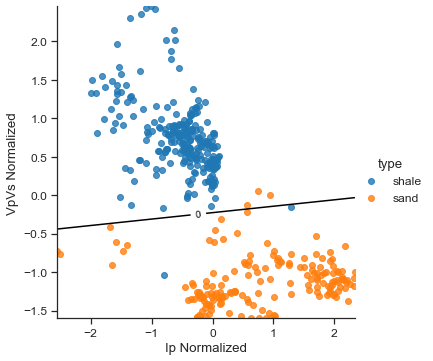

In [27]:
w0 = np.zeros(d) # initial weights
alpha = 1        # learning rate
iters = 200      # number of iterations

w, ws = gradientDescent(dJ_SVM, X, y, w0, alpha, iters)
print(f"optimal weights w: {w}")

plot_fit(h, w) 